# Volumetrics: HCIP calculation

We'll implement the volumetric equation:

$$ V = A \times T \times G \times \phi \times N\!\!:\!\!G \times S_\mathrm{O} \times \frac{1}{B_\mathrm{O}} $$

## Gross rock volume 

$$ \mathrm{GRV} = A \times T $$

In [1]:
thick = 80            # metres
area = 20000 * 30000  # metres

grv = thick * area
grv

48000000000

Make a <bold>function</bold> that computes the GRV.

In [2]:
def calculate_grv(thickness, area):
    return thickness * area

Now we can just call this function, instead of remembering the equation. (Admittedly, the equation is rather easy to remember in this case!)

In [3]:
calculate_grv(thick, area)

48000000000

It works!

Now we need to compensate for the prospect not being a flat slab of rock &mdash; using the geometric factor. 

We will implement the equations implied by this diagram:

<html><img src="http://subsurfwiki.org/images/6/66/Geometric_correction_factor.png", width=600></html>

Turn this one into a function.

In [4]:
def geometric_factor(thick, height, top='slab'):

    ratio = thick / height

    if top == 'round':
        g = -0.6 * ratio + 1
    elif top == 'flat':
        g = -0.3 * ratio + 1
    else:
        g = 1

    return g

In [6]:
geometric_factor(thick, height=100, top='round')

0.52

What if we have multiple prospects?

In [7]:
import numpy as np

thicknesses = np.array([10, 25, 15, 5, 100])
heights = np.array([75, 100, 20, 100, 200])

In [8]:
geometric_factor(thicknesses, heights, top='round')

array([0.92, 0.85, 0.55, 0.97, 0.7 ])

Awesome, everything just works.

## HC pore volume

We need:

- net:gross &mdash; the ratio of reservoir-quality rock thickness to the total thickness of the interval.
- porosity
- $S_\mathrm{O}$ &mdash; the oil saturation, or proportion of oil to total pore fluid.

In [9]:
netg = 0.5   # fraction
por = 0.24   # fraction
s_o = 0.8    # fraction

hcpv = netg * por * s_o

### EXERCISE

- Turn this into a function by rearranging the following lines of code:

In [10]:
def calculate_hcpv(netg, por, s_o):
    """A function to compute the hydrocarbon pore volume."""
    hcpv = netg * por * s_o
    return hcpv

## Formation volume factor

Oil shrinks when we produce it, especially if it has high GOR. The FVF, or $B_O$, is the ratio of a reservoir barrel to a stock-tank barrel (25 deg C and 1 atm). Typically the FVF is between 1 (heavy oil) and 1.7 (high GOR).

In [11]:
fvf = 1.1

## Put it all together

Now we have the components of the volumetric equation:

In [12]:
hcip = grv * hcpv / fvf
hcip

4189090909.0909085

6.3 barrels per metre-cubed.

In [13]:
hcip * 6.2898

26348543999.999996

In [14]:
# Solution.
def calculate_hcip(thickness, area, height, top, netg, por, s_o, fvf):
    grv = calculate_grv(thickness, area)
    g = geometric_factor(thickness, height, top)
    grv *= g
    hcpv = calculate_hcpv(netg, por, s_o)
    return grv * hcpv / fvf

In [15]:
height = 100
top = 'slab'

calculate_hcip(thick, area, height, top, netg, por, s_o, fvf)

4189090909.0909085

In [16]:
fvfs = np.arange(1, 1.7, 0.01)

hcips = calculate_hcip(thick, area, height, top, netg, por, s_o, fvfs)

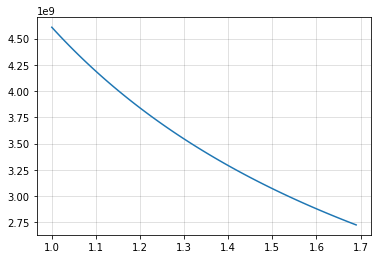

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(fvfs, hcips)
plt.grid(color='k', alpha=0.15)

## Monte Carlo simulation

We can easily draw randomly from distributions of properties:

In [18]:
import numpy as np

np.random.random(5)

array([0.89175891, 0.47449348, 0.00140556, 0.88594532, 0.68599035])

In [19]:
netg = np.random.normal(loc=0.5, scale=0.1, size=100)
por = np.random.normal(loc=0.15, scale=0.025, size=100)

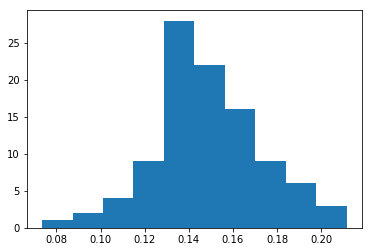

In [20]:
_ = plt.hist(por)

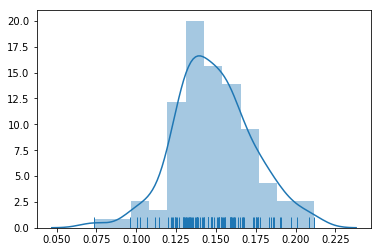

In [21]:
import seaborn as sns

sns.distplot(por, rug=True)

In [22]:
hcpv = calculate_hcpv(netg, por, s_o)
hcpv

array([0.04374621, 0.03896921, 0.0960101 , 0.05041647, 0.03236557,
       0.08650655, 0.06596693, 0.04745396, 0.07698983, 0.05939264,
       0.07420392, 0.0703756 , 0.06630843, 0.04065243, 0.04370854,
       0.06623395, 0.06771298, 0.05261654, 0.05308858, 0.05208025,
       0.06011493, 0.06358032, 0.04909324, 0.05304784, 0.08117952,
       0.06160674, 0.05124534, 0.04332111, 0.04575289, 0.05400401,
       0.0634681 , 0.09613887, 0.05253359, 0.09155105, 0.05860475,
       0.07144544, 0.07187239, 0.07281785, 0.05672949, 0.04393293,
       0.0411256 , 0.05991384, 0.05559259, 0.04812046, 0.03891026,
       0.04198024, 0.07646696, 0.0175202 , 0.07120687, 0.03512416,
       0.05718246, 0.06087617, 0.058577  , 0.0524364 , 0.07369963,
       0.05120432, 0.07944743, 0.06995089, 0.04532123, 0.06418472,
       0.06505186, 0.03142918, 0.05424793, 0.0634104 , 0.08714167,
       0.08568632, 0.03995346, 0.08919954, 0.05720459, 0.03977687,
       0.05626217, 0.05184736, 0.05850428, 0.05198617, 0.04889

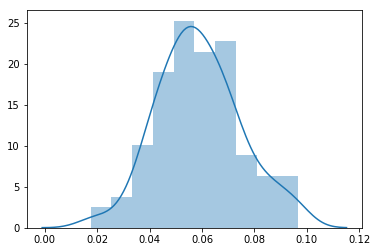

In [23]:
sns.distplot(hcpv)

In [24]:
hcpv.mean()

0.05887203861265828

The histogram looks a bit ragged, but this is probably because of the relatively small number of samples.

### EXERCISE

1. Compute HCIP with these distributions. Make a histogram of the result in millions of barrels.
1. How does the histogram look if you take 1000 samples instead of 100?
1. Make distributions for some of the other properties, like thickness and FVF.

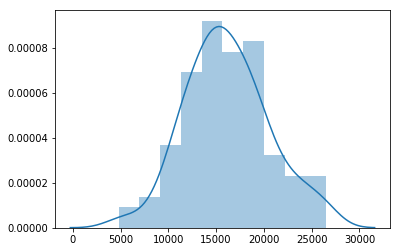

In [25]:
hcip = calculate_hcip(thick, area, height, top, netg, por, s_o, fvf)
sns.distplot(hcip * 6.2898 / 1e6)

## Spreadsheet of prospects

In [26]:
import pandas as pd

uid = "1P2JxXG_jLZ0vx8BlFvm0hD6sBBZH2zU8tk9T-SI27mE"
url = f"https://docs.google.com/spreadsheets/d/{uid}/export?format=csv"

df = pd.read_csv(url)
df.head()

,Index,Name,Thick [m],Area [km2],GeomFactor,N:G,phi,So,Bo
0,0,Prospect_1,173,65.714854,0.73,0.26,0.150557,0.45,1.10
1,1,Prospect_2,410,40.684869,0.43,0.59,0.163122,0.38,1.23
2,2,Prospect_3,160,13.883810,0.55,0.16,0.167810,0.59,1.29
3,3,Prospect_4,11,5.572679,0.67,0.12,0.176766,0.29,1.20
4,4,Prospect_5,257,49.995814,0.81,0.31,0.179255,0.14,1.28


In [27]:
names = {
    'thickness': 'Thick [m]',
    'area': 'Area [km2]',
    'netg': 'N:G',
    'por': 'phi',
    's_o': 'So',
    'fvf': 'Bo'
}

In [28]:
def hcip_row(row):
    params = {k: row[v] for k, v in names.items()}
    params['height'] = 1e6
    params['top'] = 'slab'
    hcip = calculate_hcip(**params) * row['GeomFactor']
    return hcip


df['HCIP'] = df.apply(hcip_row, axis=1)

In [29]:
df.head()

,Index,Name,Thick [m],Area [km2],GeomFactor,N:G,phi,So,Bo,HCIP
0,0,Prospect_1,173,65.714854,0.73,0.26,0.150557,0.45,1.10,132.900794
1,1,Prospect_2,410,40.684869,0.43,0.59,0.163122,0.38,1.23,213.269652
2,2,Prospect_3,160,13.883810,0.55,0.16,0.167810,0.59,1.29,15.003450
3,3,Prospect_4,11,5.572679,0.67,0.12,0.176766,0.29,1.20,0.210537
4,4,Prospect_5,257,49.995814,0.81,0.31,0.179255,0.14,1.28,63.256274


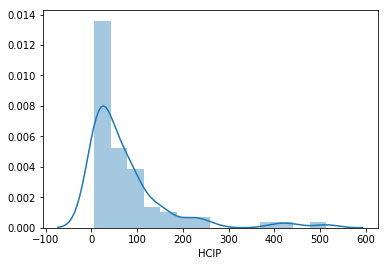

In [30]:
sns.distplot(df.query('HCIP>5').HCIP)

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2016</p>
</div>